# **HOPOMO IMPLEMENTATION**




### **IMPORTS**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd


### **PARAMETRES**



In [ ]:
# Comportements de la reine/ponte
x1=385
x2=30
x3=36
x4=155 #jour de l'année où la reine pond le plus
x5=30
ELRbase=1600 # taux de ponte moyen de la reine (dépend de la reine, son âge etc ..)
SUPtreshold=0.2 # si le taux de cellules vides est inférieur à cette limite alors il y a une diminution du taux de ponte (la reine a de plus en plus de mal à trouver des cellules disponibles)
ELRstochrange=0 # facteur stochastique du taux de ponte de la reine

# Cellules
CELLShive=250000 # nb de cellules dans la ruche

# Couvain
LIFESPANegg =3 #durée max (en jours) de l'état oeuf
LIFESPANlarvae =5 #durée max (en jours) de l'état larve
LIFESPANpupae =12 #durée max (en jours) de l'état pupe 
MORTALITYeggs=0.03 # Mortalités (Plus le stade est avancé et moins le taux de mortalité est élevé)
MORTALITYlarvae=0.01
MORTALITYpupae=0.001
CANNIBALISMbase=[0.23,0.3,0.58,0.06,0]  # Taux fixe de cannibalisme des larves en fonction de leur age (1-5 jours)

# Abeilles adultes
MORTALITYadultbase=0.01
MORTALITYnursing = 0.005
MORTALITYprocessing=0.005
MORTALITYforaging=0.035

# Facteurs liés aux ressources
FACTORpollensavingmax = 0.30
ratioNectar = 0.4
FACTORothertasks = 0.2
FACTORpollenstorage = 6
FACTORminpollenforagers = 0.01
FACTORforagingmax=0.33

# Besoins
NECTARNEEDactiveforager = 0.08 # à établir
NECTARNEEDnurse = 0.08 #à établir
NECTARNEEDadult = 0.08 #à établir
NECTARNEEDlarva = [0.04,0.05,0.06,0.07,0.08] # à établir
POLLENNEEDlarva = [0.04,0.05,0.06,0.07,0.08] # à établir
POLLENNEEDadult = 0.08 # à établir
POLLENNEEDnurse = 0.08 # à établir
NEEDnurses_per_larva=[1,2,3,4,5] # à déterminer, augmentation exponentielle grandissant avec la masse de la larve
NEEDnurses_per_egg=1 # à établir, moins important que pour les larves car pas besoin d'être nourrit
NEEDnurses_per_pupa=1 # à établir, moins important que pour les larves car pas besoin d'être nourrit

#Butinage
LOADpollenforager = 0.06
LOADnectarforager=0.04
FACTORforagingsuccess=0.8
TURNSnectarforager= 15
TURNSpollenforager=10
RATIOnectar_to_honey=0.4
ProcessorsPerCell = 2
stochasticForagingFactor = 0.25

# Poids (en grammes)
w_hivebase = 14000 # 
w_cellsbase = 0.037 #represents the weight of one empty cell (wax only).
w_pollen = 0.23 # poids d'une cellule remplie de pollen
w_nectar = 0.43 # poids d'une cellule remplie de nectar
w_honey = 0.5 #poids d'une cellule remplie de miel
w_egg = 0.0001
w_pupa = 0.16
w_larva = [0.0002,0.00059,0.00331,0.0644,0.160] #le poids d'une larve à l'état i ∈ {1,2,3,4,5}
w_adult = 0.1

### **FACTEUR SAISON (2.1)**


In [ ]:
#--------------------------------------------------------------#

def f(t):
  return(1-1/(1+x1*np.exp(-2*t/x2)))

#--------------------------------------------------------------#

def g(t):
  return(1/(1+x3*np.exp(-2*(t-x4)/x5))) 

#--------------------------------------------------------------#  

#Facteur saison (t en jours [max 365 jours])
def season(t):
    return max(g(t),f(t))

#--------------------------------------------------------------#

### **CELLULES DANS LA RUCHE ET TAUX DE PONTE (2.1)**

In [ ]:

#--------------------------------------------------------------#

# Nombre de cellules disponibles (vides)
def CELLSempty(t) :
  if (t<=0):
    return CELLShive

  else :
    return CELLShive - CELLSbrood(t)-STORESpollen(t)-STORESnectar(t)-STOREShoney(t)

#--------------------------------------------------------------#

# Fonction décrivant la diminution du taux de ponte lorsque le nombre de cellules disponibles devient limité 
def SUPcomb(t):
  res = CELLSempty(t)/(CELLShive+1)
  if (res <SUPtreshold):
    return res / SUPtreshold
  else :
    return 1  

#--------------------------------------------------------------#

# Facteur stochastique (aléatoire) du taux de ponte
def ELRstoch():
  return rd.uniform(-ELRstochrange,ELRstochrange)

#--------------------------------------------------------------#

# Fonction prédictive du taux de ponte de la reine 
def ELR(t):
    return ELRbase*(1+ELRstoch())*(1-season(t))*SUPcomb(t)  

#--------------------------------------------------------------#    

### **OEUFS DANS LA RUCHE (2.2)**

In [ ]:
#--------------------------------------------------------------#    

# Nombre d'oeuf au stade i à un instant t
def EGGS(i,t):
    if (t<=0) :
      return 0
    # i désigne l'âge de l'individu immature, t le jour
    if i==1 :
      return ELR(t-1) * (1-MORTALITYeggs)
    elif i==2 or i==3 :
      return EGGS(i-1,t-1)*(1-MORTALITYeggs)
    else :
      # Exception, la fonction EGGS n'est pas définie pour i qui n'appartient pas à [|1;3|]
      print('Erreur, l age i n est pas possible pour la fonction EGGS daprès le modele')
      return (-1)

#--------------------------------------------------------------#    

# Nombre de cellules contenant des oeufs dans la ruche à un instant t 
def CELLSeggs(t):
  # Nombre total d'oeuf dans la ruche à un instant t 
  return sum([EGGS(i,t) for i in range(1,LIFESPANegg+1)])

#--------------------------------------------------------------#   

### **LARVES DANS LA RUCHE (2.2)**

In [ ]:
#--------------------------------------------------------------#

# Taux de cannibalisme des larves
def CANNIBALISMlarvae(i,t) :
  return(CANNIBALISMbase[i-1] *(1-(INDEXpollensituation(t-1)*INDEXnursingquality(t-1))))

#--------------------------------------------------------------#  

# Taux de larves survivantes
def SURVIVALlarvae(i,t):
  return((1-CANNIBALISMlarvae(i,t))*(1-MORTALITYlarvae))

#--------------------------------------------------------------#  

# Nombre de larves au stade i à un instant t
def LARVAE(i,t):
  if (t<=0) :
    return 0
  # i désigne l'âge de l'individu immature, t le jour
  if i==1 :
    return EGGS(LIFESPANegg,t-1)*SURVIVALlarvae(1,t)
  elif i>1 and i<=LIFESPANlarvae :
    return LARVAE(i-1,t-1)*SURVIVALlarvae(i,t)
  else :
    # Exception, la fonction LARVAE n'est pas définie pour i qui n'appartient pas à [|1;LIFESPANlarvae|]
    print('Erreur, l age i n est pas possible pour la fonction LARVAE daprès le modele')
    return (-1)

#--------------------------------------------------------------#

# Nombre de cellules contenant des larves dans la ruche à un instant t 
def CELLSlarvae(t):
  # Nombre total de larves dans la ruche à un instant t  
  return sum([LARVAE(i,t) for i in range(1,LIFESPANlarvae+1)])

#--------------------------------------------------------------#

### **PUPES DANS LA RUCHE (2.2)**

In [ ]:
#--------------------------------------------------------------#

# Nombre de pupes au stade i à un instant t
def PUPAE(i,t):
  if (t<=0) :
    return 0
  # i désigne l'âge de l'individu immature, t le jour
  if i==1 :
    return LARVAE(LIFESPANlarvae,t-1)*(1-MORTALITYpupae)
  elif i>1 and i<=LIFESPANpupae :
    return PUPAE(i-1,t-1)*(1-MORTALITYpupae)
  else :
    # Exception, la fonction PUPAE n'est pas définie pour i qui n'appartient pas à [|1;LIFESPANpupae|]
    print('Erreur, l age i n est pas possible pour la fonction PUPAE daprès le modele')
    return (-1)

#--------------------------------------------------------------#

# Nombre de cellules contenant des pupes dans la ruche à un instant t 
def CELLSpupae(t):
  # Nombre total de pupes dans la ruche à un instant t  
  return sum([PUPAE(i,t) for i in range(1,LIFESPANpupae+1)])

#--------------------------------------------------------------#

### **CELLULES DU COUVAIN DANS LA RUCHE (2.2)**

In [ ]:
#--------------------------------------------------------------#

def CELLSbrood(t):
  # Nombre d'individus en phase de développement dans la ruche (oeufs+larves+pupes)
  return CELLSeggs(t) + CELLSlarvae(t) + CELLSpupae(t)

#--------------------------------------------------------------#  

### **MORTALITE DES ABEILLES ADULTES (2.3)**

In [ ]:
#--------------------------------------------------------------#

# Taux de mortalité des abeilles adultes à un instant t
def MORTALITYadult(t):
  return MORTALITYadultbase + MORTALITYnursing*(NURSES(t-1)/(BEESadult(t-1)+1))+MORTALITYprocessing*(PROCESSORS(t-1)/(BEESadult(t-1)+1))+MORTALITYforaging*(FORAGERSactive(t-1)/(BEESadult(t-1)+1))

#--------------------------------------------------------------#

# Nombre d'abeilles adultes à un instant t
def BEESadult(t):
  if (t<=0) :
    return 0
  else :
    return (BEESadult(t-1)+PUPAE(LIFESPANpupae,t-1))*(1-MORTALITYadult(t))

#--------------------------------------------------------------#

### **INFLUENCE DE LA TEMPERATURE ET DU CLIMAT SUR LE BUTINAGE (2.4)**

In [ ]:
#--------------------------------------------------------------#

# Etant donné un jour de l'année (entre 1 et 365) renvoie son mois associé
def mois(t):
  if (isinstance(t,int)) :

    if (t>= 1 and t<=31 ):
      # Janvier
      return 1
    
    #Dans le modèle on considère une année commune et non bissextile. Février -> 28 jours
    if (t>= 32 and t<=59 ):
      #Février
      return 2

    if (t>= 60 and t<=90 ):
      # Mars
      return 3  

    if (t>= 91 and t<=120 ):
      # Avril
      return 4 

    if (t>= 121 and t<=151):
      # Mai
      return 5
    
    if (t>= 152 and t<=181):
      # Juin
      return 6

    if (t>= 182 and t<=212):
      # Juillet
      return 7  
    
    if (t>= 213 and t<=243):
      # Août
      return 8    
    
    if (t>= 244 and t<=273):
      # Septembre
      return 9
    
    if (t>= 274 and t<=304):
      # Octobre
      return 10

    if (t>= 305 and t<=334):
      # Novembre
      return 11
        
    if (t>= 335 and t<=365):
      # Décembre
      return 12
  
  else :
    # t n'est pas entier ou n'appartient pas à [|1;365|]
    return -1

#--------------------------------------------------------------#  

# Donne la température pour le jour t 
def TEMP(t):
  # On utilise la temperature moyenne de Pau (Béarn) en 2020 par mois (de Janvier à Décembre)
  # Source : https://www.historique-meteo.net/france/aquitaine/pau-bearn/2020/
  temp_moy=[11,14,13,18,20,21,25,27,25,16,16,8]
  return temp_moy[mois(t)-1]

#--------------------------------------------------------------#  

# Donne la durée (en heures) pedant laquelle il pleut lorsqu'il fait jour 
def HOURSraining_during_daylight(t):
  mois_courant = mois(t)
  # Janvier Avril, Mai et Novembre sont les mois les plus pluvieux
  if (mois_courant ==1 or mois_courant ==4 or mois_courant ==5 or mois_courant ==11):
    hoursdaylight=HOURSdaylight(t)
    rdm = rd.randint(1,3)
    if (rdm == 1):
      return (hoursdaylight /4)

    elif (rdm == 2) :
      return  (hoursdaylight / 2)

    else :
      return (hoursdaylight)  
        
  # On considère que pour les autres mois la pluie n'affecte pas le butinage
  else :
    return 0 

  # Source pluies : https://www.ou-et-quand.net/partir/quand/france/aquitaine/pau-bearn/#:~:text=En%20moyenne%2C%20les%20mois%20les,Janvier%2C%20Avril%2C%20Mai%20et%20Novembre
 
#--------------------------------------------------------------#  

# Donne la durée (en heures) pedant laquelle il pleut lorsqu'il fait jour
def HOURSdaylight(t):
  mois_courant = mois(t)
  
  # Source : http://calendriersolaire.com/fr/pau
  lumierejour = [9,11,13,16]
  if (mois_courant == 1 or mois_courant == 2 or mois_courant ==12):
    return lumierejour[0]
  
  if (mois_courant==3 or mois_courant==4 or mois_courant==10 or mois_courant==11):
    return lumierejour[1]
  
  if (mois_courant == 5 or mois_courant ==9):
    return lumierejour[2]

  if (mois_courant >= 6 and mois_courant <=8):
    return lumierejour[3]

  #Erreur de mois, t'es n'appartient pas à [|1;365|]
  return(-1)


#--------------------------------------------------------------#

# Taux de pluie lorsqu'il fait jour
def RAIN(t):
  if (t <=0):
    return 0
  else:
    return (HOURSraining_during_daylight(t)/HOURSdaylight(t))

#--------------------------------------------------------------#

 
# Proche de 1 -> la pluie n'a pas empêché les abeilles d'aller butiner au jour t. 
# Proche de 0 -> la pluie a empêché les abeilles d'aller butiner pendant la quasi totalité de la journée.
def INDEXrain(t):
  return 1-RAIN(t)

#--------------------------------------------------------------#  Facteur saison

# Proche de 1 -> la température était favorable au butinage au jour t. 
# Proche de 0 -> la température a empêché les abeilles d'aller butiner pendant la quasi totalité de la journée.
def INDEXtemperature(t):
  if (t<= 0):
    return 0
  else:
    temp = TEMP(t)
    if (temp <= 14):
      return 0
    
    if (temp > 14 and temp <= 22):
      return (temp-14)/8

    if (temp > 22 and temp <= 32):
      return 1
    
    if (temp > 32 and temp <= 40):
      return (40-temp)/8  
    
    if (temp > 40):
      return 0

#--------------------------------------------------------------# 

# Proche de 1 -> Les conditions climatiques étaient favorables au butinage. 
# Proche de 0 -> Les conditions climatiques ont empêché les abeilles d'aller butiner pendant la quasi totalité de la journée.
def INDEXflight(t):
  return INDEXrain(t) * INDEXtemperature(t)

#--------------------------------------------------------------# 

def INDEXnectaroutside(t):
  return min((1-season(t))*1.5,1)

#--------------------------------------------------------------# 

def INDEXpollenoutside(t):
  return min((1-season(t))*1.5,1)

#--------------------------------------------------------------#

### **DECISION ET REGULATION DES TACHES DE TRAVAIL (2.5 et 2.6)**

In [ ]:
#--------------------------------------------------------------#

def NEEDworkers(t):
	return NEEDnurses(t)+NEEDpollenforagers(t)

#--------------------------------------------------------------#

def RATIOworkforce(t):
	ratio=(BEESadult(t)*(1-FACTORothertasks))/(NEEDworkers(t)+1)
	if ratio<1:
		return ratio
	else:
		return 1

#--------------------------------------------------------------#

def NEEDnurses(t):
	total=0
	for i in range(1,LIFESPANlarvae+1):
		total+=LARVAE(i,t)*NEEDnurses_per_larva[i-1]
	return total+(CELLSeggs(t)*NEEDnurses_per_egg)+(CELLSpupae(t)*NEEDnurses_per_pupa)

#--------------------------------------------------------------#

def NURSES(t):
	return NEEDnurses(t)*RATIOworkforce(t)

#--------------------------------------------------------------#

def INDEXnursingquality(t):
	return NURSES(t)/(NEEDnurses(t)+1)

#--------------------------------------------------------------#

### **BUTINAGE ET BESOINS EN RESSOURCES (2.7)**

In [ ]:
#--------------------------------------------------------------#

# Nombre de butineuses
def FORAGERS(t):
	return FORAGERSpollen(t) + FORAGERSnectar(t)

#--------------------------------------------------------------#

# Calculate the actual number of foragers that fly out
# Parameter :
#	t : day number
def FORAGERSactive(t):
	return FORAGERSpollenactive(t) + FORAGERSnectaractive(t)

#--------------------------------------------------------------#

def FORAGERSnectaractive(t):
  return FORAGERSnectar(t)*INDEXflight(t)*INDEXnectaroutside(t)

#--------------------------------------------------------------#

def FORAGERSnectar(t):
  return min(BEESadult(t)*FACTORforagingmax-FORAGERSpollen(t),WORKFORCEnectar(t)-PROCESSORS(t))

#--------------------------------------------------------------#

def NEEDpollen(t): 
  if (t<=0):
    return 0
  else:
    return NEEDpollen_larvae(t)+NEEDpollen_adult(t)

#--------------------------------------------------------------#

# Returns the pollen demands of the larvae of all ages (i)
# Parameter :
#	t : day number
def NEEDpollen_larvae(t):
	res = 0
	for i in range(1,LIFESPANlarvae+1):
		res = res + POLLENNEEDlarva[i-1]*LARVAE(i,t)
	return res

#--------------------------------------------------------------#

# The adult’s pollen demand is calculated by adding the 
# basic daily pollen demand of adult bees (a constant, 
# POLLEN-NEEDadult) and an additional daily pollen demand
#of nursing bees (a constant, POLLENNEEDnurse).
# Parameter :
#	t : day number
def NEEDpollen_adult(t):
	return BEESadult(t)*POLLENNEEDadult + NURSES(t)*POLLENNEEDnurse

#--------------------------------------------------------------#

# Returns the daily need for pollen income. We use a 
# gliding average throughout 3 days (d goes from 0 to 2) 
# to model the needed pollen income.
# Parameter :
#	t : day number
def NEEDpollenincome(t):
	acc = 0
	for d in range(0,3):
		acc = acc + NEEDpollen(t-d)
	acc = acc/3
	acc = acc * FACTORpollenstorage - STORESpollen(t)
	return max(0, acc)

#--------------------------------------------------------------#

# calculate the needed number of pollen foragers 
# NEEDpollenforagers(t).
# LOADpollenforager is the amount of pollen collected 
# per foraging trip; expressed in the unit “cellfuls”
# TURNSpollenforager is the number of trips performed 
# per forager per day
# Parameter :
#	t : day number
def NEEDpollenforagers(t):
	return (NEEDpollenincome(t-1) / (LOADpollenforager*TURNSpollenforager*FACTORforagingsuccess))

#--------------------------------------------------------------#

# Models the potential number of pollen foragers 
# each day.
# Parameter :
#	t : day number
def FORAGERSpollen(t):
	maximum = max(NEEDpollenforagers(t)*RATIOworkforce(t), (BEESadult(t)-NURSES(t))*FACTORminpollenforagers )
	return min(maximum, BEESadult(t)*FACTORforagingmax)

#--------------------------------------------------------------#

# Models the number of fragers that actually leave the 
# hive for foraging flights. It depends on two
# environmental factors : INDEXflight(t) expresses the 
# weather situation each day and INDEXpollenoutside(t)
# expresses the botanical pollen availability each day.
# Parameter :
#	t : day number
def FORAGERSpollenactive(t):
	return FORAGERSpollen(t)*INDEXflight(t)*INDEXpollenoutside(t)
 

#--------------------------------------------------------------#

# Models the demand for nectar (quite similar to the 
# pollen demand with the additional complication that
# the active foragers are also important nectar 
# consumers).
# Parameter :
#	t : day number
def NEEDnectar(t):
	return NEEDnectar_larvae(t) + NEEDnectar_adult(t)

#--------------------------------------------------------------#

# Returns the nectar demands of the larvae of all ages (i)
# Parameter :
#	t : day number
def NEEDnectar_larvae(t):
	acc = 0
	for i in range(1,LIFESPANlarvae+1):
		acc = acc + (NECTARNEEDlarva[i-1]*LARVAE(i,t))
	return acc

#--------------------------------------------------------------#

# Returns the nectar demands of adult bees
# Parameter :
#	t : day number
def NEEDnectar_adult(t):
	# nectar needed for adult bees
	nectar_adults = BEESadult(t)*NECTARNEEDadult

	# nectar needed for nurses
	nectar_nurses = NURSES(t)*NECTARNEEDnurse

	# nectar needed for active foragers
	nectar_foragers = FORAGERSactive(t)*NECTARNEEDactiveforager
	
	# Returns the nectar demands of adult bees
	return nectar_adults+nectar_nurses+nectar_foragers

#--------------------------------------------------------------#

# Because the number of available workers could already 
# be recruited for the high-priority jobs “nursing” and 
# “pollen foraging” (RATIOworkforce < 1), it is 
# necessary to limit WORFORCEnectar(t) to non-negative 
# values.
# Parameter :
#	t : day number
def WORKFORCEnectar(t):
	if RATIOworkforce(t)==1:
		res = BEESadult(t)*(1-FACTORothertasks)
		return res-NURSES(t)-FORAGERSpollen(t)
	else :
		return 0

#--------------------------------------------------------------#

### **FLUX DE RESSOURCES ET TRAITEMENT DE LA NOURRITURE AU SEIN DE LA COLONIE (2.8  et 2.9)**

In [ ]:
#--------------------------------------------------------------#

def INCOMEpollen(t):
    return FORAGERSpollenactive(t) * LOADpollenforager * TURNSpollenforager * FACTORforagingstoch(t) * FACTORforagingsuccess

#--------------------------------------------------------------#

def FACTORforagingstoch(t):
    return(rd.uniform(1-stochasticForagingFactor , 1+stochasticForagingFactor))

#--------------------------------------------------------------#

def INDEXpollensituation(t):
    return(min([1 , (STORESpollen(t)) / (NEEDpollen(t)*FACTORpollenstorage+1)]))

#--------------------------------------------------------------#

def INCOMEnectar(t):
    return(min([FORAGERSnectaractive(t) * LOADnectarforager * TURNSnectarforager * FACTORforagingstoch(t) * FACTORforagingsuccess , CELLSempty(t-1)]))

#--------------------------------------------------------------#

def NEEDprocessors(t):
    return STORESnectar(t-1) * ProcessorsPerCell

#--------------------------------------------------------------#

def PROCESSORS(t):
    return(min([NEEDprocessors(t) , WORKFORCEnectar(t)]))

#--------------------------------------------------------------#

def PROCESSEDnectar(t):
    return(min([STORESnectar(t-1) - USAGEnectar(t) , PROCESSORS(t) / ProcessorsPerCell]))

#--------------------------------------------------------------#

### **GESTION DES RESSOURCES ET TRAITEMENT (2.10)**

In [ ]:
#--------------------------------------------------------------#
def USAGEnectar(t):
    liste_var = []
    needNectar_var = NEEDnectar(t)
    storeNectar_var = STORESnectar(t-1)
    liste_var.append(needNectar_var)
    liste_var.append(storeNectar_var)
    return min(liste_var)

#--------------------------------------------------------------#

def USAGEpollen(t):
    liste_var = []
    needPollen_var = NEEDpollen(t-1)*(1-(FACTORpollensavingmax*(1-INDEXpollensituation(t-1))))
    storePollen_var = STORESpollen(t-1)

    liste_var.append(needPollen_var)
    liste_var.append(storePollen_var)
    return min(liste_var)

#--------------------------------------------------------------#

def USAGEhoney(t):
    liste_var = []
    storeHoney_var = STOREShoney(t-1)
    nectar_var = (NEEDnectar(t)-USAGEnectar(t))
    liste_var.append(storeHoney_var)
    liste_var.append(nectar_var)
    liste_var.append(ratioNectar)
    return min(liste_var)


#--------------------------------------------------------------#

def STORESpollen(t):
    if (t<=0):
      return 0
    else:
      return STORESpollen(t-1)+INCOMEpollen(t)-USAGEpollen(t)

#--------------------------------------------------------------#

def STORESnectar(t):
  if (t<=0):
    return 0
  else :
    return STORESnectar(t-1)+INCOMEnectar(t)-USAGEnectar(t)-PROCESSEDnectar(t)

#--------------------------------------------------------------#

def STOREShoney(t):
  if (t<=0):
    return 0
  else :  
    return STOREShoney(t-1)-USAGEhoney(t)+(PROCESSEDnectar(t)*ratioNectar)

#--------------------------------------------------------------#

#Result in kilogramme
def WEIGHTcolony(t):
  somme_res = 0
  for i in range (1, LIFESPANlarvae):
    somme_res += w_larva[i-1]*LARVAE(i,t)
  return 1/1000 * (w_hivebase + (w_cellsbase * CELLShive) + (w_pollen * STORESpollen(t)) + (w_nectar * STORESnectar(t)) + (w_honey * STOREShoney(t)) + (w_egg * CELLSegg(t)) + (w_pupa * CELLSpupae(t)) + somme_res + w_adult * BEESadult(t) )

#--------------------------------------------------------------#

def BEESlazy(t):
    return (BEESadult(t)*(1-FACTORothertasks))-FORAGERSactive(t)-NURSES(t)-PROCESSORS(t)

#--------------------------------------------------------------#

### **TEST DES FONCTIONS**

KeyboardInterrupt: ignored

### **PLOTS**

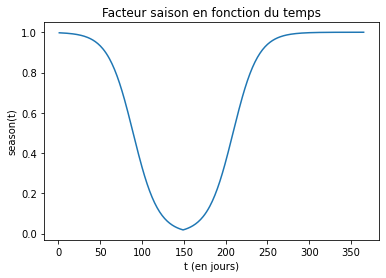

In [ ]:
# Facteur saison (2.1)
X=[i for i in range(1,366)] 
Y=[season(i) for i in X]

plt.title('Facteur saison en fonction du temps')
plt.ylabel('season(t)')
plt.xlabel('t (en jours)')

plt.plot(X,Y)
plt.show()

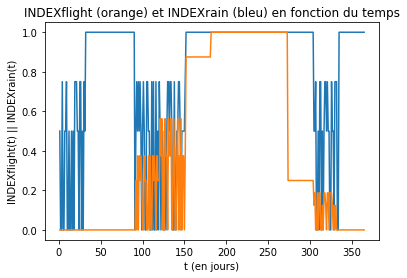

In [ ]:
# Facteurs climatiques  (2.4)
X=[i for i in range(1,366)] 
Y=[INDEXrain(i) for i in X] #Bleu
Y2=[INDEXflight(i) for i in X] #Orange

plt.title('INDEXflight (orange) et INDEXrain (bleu) en fonction du temps')
plt.ylabel('INDEXflight(t) || INDEXrain(t)')
plt.xlabel('t (en jours)')


plt.plot(X,Y)
plt.plot(X,Y2)


plt.show()

### INTERPRETATION
# On rappelle que les valeurs proches de 1 indiquent que les conditions (temperature, pluie) sont favorables au butinage et celles proches de 0 sont défavorables.
# Pendant l'hiver, les faibles temperatures empêchent les abeilles d'aller butiner. C'est tout le contraire en été, où les conditions climatiques sont excellentes.
# De plus le facteur aléatoire lié à la pluie a un impact néfaste durant la période pluvieuse ce qui se traduit relativement bien sur ce modèle très simpliste.


In [ ]:
print("test")

test
